<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

2023-12-07 12:33:53.220482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 12:33:57.426685: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2023-12-07 12:33:57.427455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2023-12-07 12:33:57.42

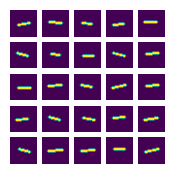

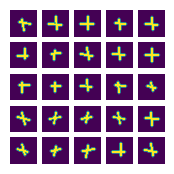

In [4]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [5]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 [==============================] - 1s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #9070

X_text: "45+35" = y_text: "80 "


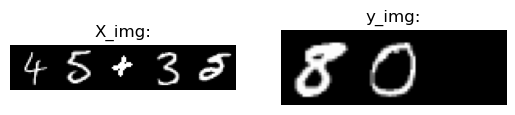

Query #6456

X_text: "32+28" = y_text: "60 "


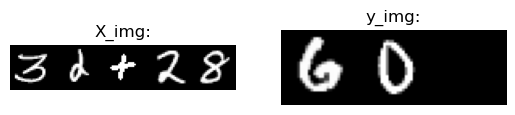

Query #5478

X_text: "27+39" = y_text: "66 "


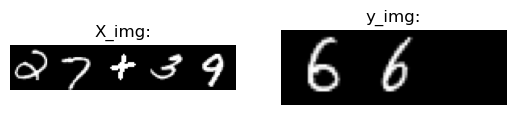

Query #8686

X_text: "43+43" = y_text: "86 "


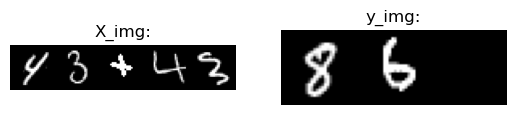

Query #8439

X_text: "42-19" = y_text: "23 "


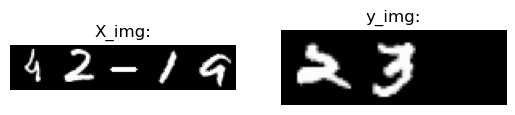

Query #9723

X_text: "48-61" = y_text: "-13"


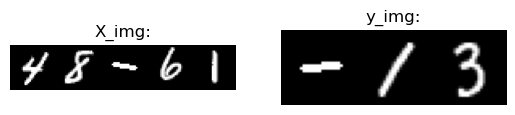

Query #9962

X_text: "49+81" = y_text: "130"


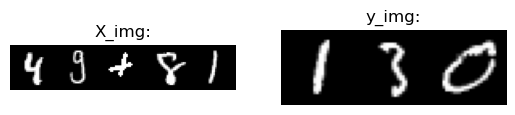

Query #1821

X_text: "9-10 " = y_text: "-1 "


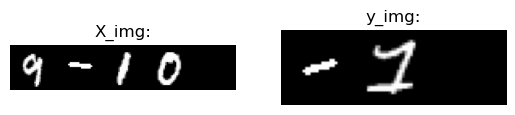

Query #2467

X_text: "12-33" = y_text: "-21"


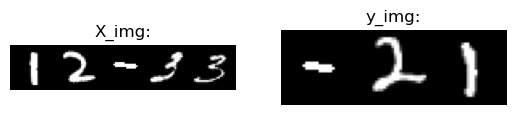

Query #8316

X_text: "41+58" = y_text: "99 "


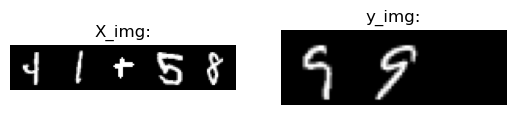

In [6]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [7]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters), return sequences=False)))
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

The first experiment we conducted involved distributing the dataset into training and testing sets in the following proportions: 50 percent of train - 50 percent of test; 25 percent of train - 75 percent of test, 10 percent of train, 90 percent of test. Output the accuracy and loss of training and the misclassified ten samples.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed (TimeDist  (None, 3, 13)             3341      
 ributed)                                                        
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
469/469 [

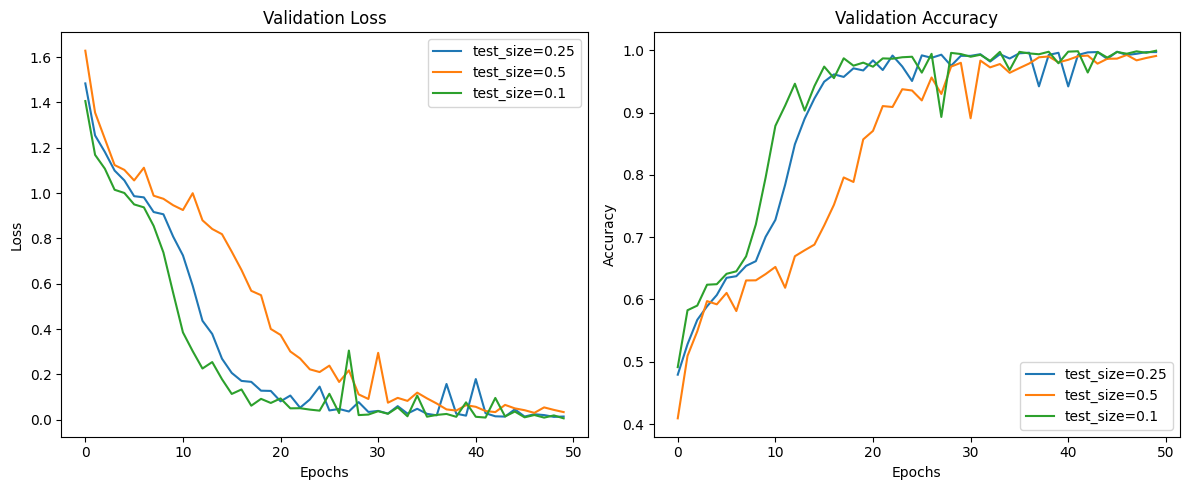

63/63 [==============================] - 1s 3ms/step
Sample 650: Predicted - '8  ', True - '7  '
Sample 1028: Predicted - '29 ', True - '19 '
Sample 1073: Predicted - '29 ', True - '19 '
Sample 1779: Predicted - '70 ', True - '80 '


In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):
test_sizes = [0.25, 0.5, 0.1]
results = {size: {'loss': [], 'accuracy': []} for size in test_sizes}

for size in test_sizes:
    X_text_train, X_text_val, y_text_train, y_text_val = train_test_split(X_text, y_text, test_size=size, random_state=42)
    X_text_train_onehot = encode_labels(X_text_train)
    X_text_val_onehot = encode_labels(X_text_val)
    y_text_train_onehot = encode_labels(y_text_train)
    y_text_val_onehot = encode_labels(y_text_val)

    model = build_text2text_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_text_train_onehot, y_text_train_onehot, batch_size=32, epochs=50, validation_data=(X_text_val_onehot, y_text_val_onehot))

    results[size]['loss'].extend(history.history['val_loss'])
    results[size]['accuracy'].extend(history.history['val_accuracy'])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for size, result in results.items():
    plt.plot(result['loss'], label=f'test_size={size}')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for size, result in results.items():
    plt.plot(result['accuracy'], label=f'test_size={size}')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()

y_pred_val_onehot = model.predict(X_text_val_onehot)

y_pred_val = [decode_labels(pred) for pred in y_pred_val_onehot]
y_true_val = [decode_labels(true) for true in y_text_val_onehot]

incorrect_predictions = []
for i in range(len(y_true_val)):
    if y_pred_val[i] != y_true_val[i]:
        incorrect_predictions.append((i, y_pred_val[i], y_true_val[i]))

for idx, pred, true in incorrect_predictions[:10]:
    print(f"Sample {idx}: Predicted - '{pred}', True - '{true}'")







add more LSTM layers to see performance comparison

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_3 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed_3 (TimeDi  (None, 3, 13)             3341      
 stributed)                                                      
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/60
469/469

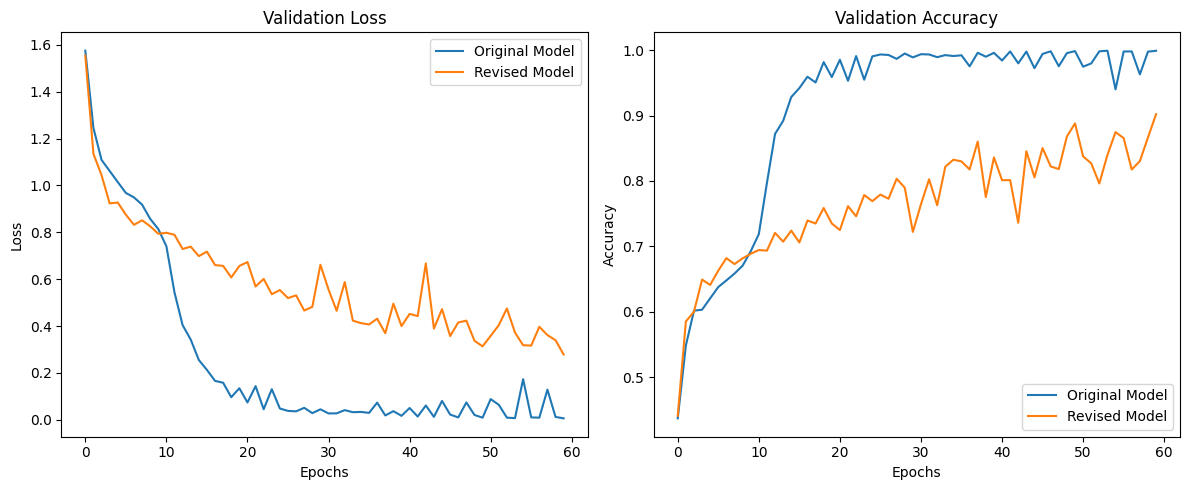

In [ ]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

def build_text2text_model_revised():
    text2text = tf.keras.Sequential()
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=False))
    text2text.add(RepeatVector(max_answer_length))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

test_size = 0.25
results = {'original': {'loss': [], 'accuracy': []}, 'revised': {'loss': [], 'accuracy': []}}


X_text_train, X_text_val, y_text_train, y_text_val = train_test_split(X_text, y_text, test_size=test_size, random_state=42)
X_text_train_onehot = encode_labels(X_text_train)
X_text_val_onehot = encode_labels(X_text_val)
y_text_train_onehot = encode_labels(y_text_train)
y_text_val_onehot = encode_labels(y_text_val)


model_original = build_text2text_model()
model_original.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_original = model_original.fit(X_text_train_onehot, y_text_train_onehot, batch_size=32, epochs=60, validation_data=(X_text_val_onehot, y_text_val_onehot))
results['original']['loss'].extend(history_original.history['val_loss'])
results['original']['accuracy'].extend(history_original.history['val_accuracy'])


model_revised = build_text2text_model_revised()
model_revised.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_revised = model_revised.fit(X_text_train_onehot, y_text_train_onehot, batch_size=32, epochs=60, validation_data=(X_text_val_onehot, y_text_val_onehot))
results['revised']['loss'].extend(history_revised.history['val_loss'])
results['revised']['accuracy'].extend(history_revised.history['val_accuracy'])


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(results['original']['loss'], label='Original Model')
plt.plot(results['revised']['loss'], label='Revised Model')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['original']['accuracy'], label='Original Model')
plt.plot(results['revised']['accuracy'], label='Revised Model')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig('model_comparison.png')
plt.show()


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
# Your code

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

(15000, 3, 28, 28)
6+33 
Epoch 1/50
469/469 [==============================] - 18s 20ms/step - loss: 0.0567 - accuracy: 0.8645 - val_loss: 0.0486 - val_accuracy: 0.8656
Epoch 2/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0482 - accuracy: 0.8643 - val_loss: 0.0471 - val_accuracy: 0.8655
Epoch 3/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0472 - accuracy: 0.8634 - val_loss: 0.0465 - val_accuracy: 0.8647
Epoch 4/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0467 - accuracy: 0.8628 - val_loss: 0.0465 - val_accuracy: 0.8645
Epoch 5/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0463 - accuracy: 0.8623 - val_loss: 0.0458 - val_accuracy: 0.8629
Epoch 6/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0460 - accuracy: 0.8620 - val_loss: 0.0455 - val_accuracy: 0.8627
Epoch 7/50
469/469 [==============================] - 9s 20ms/step - loss: 0.0456 - accuracy: 0.8617 - val_loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training history saved to 'training_history.txt'


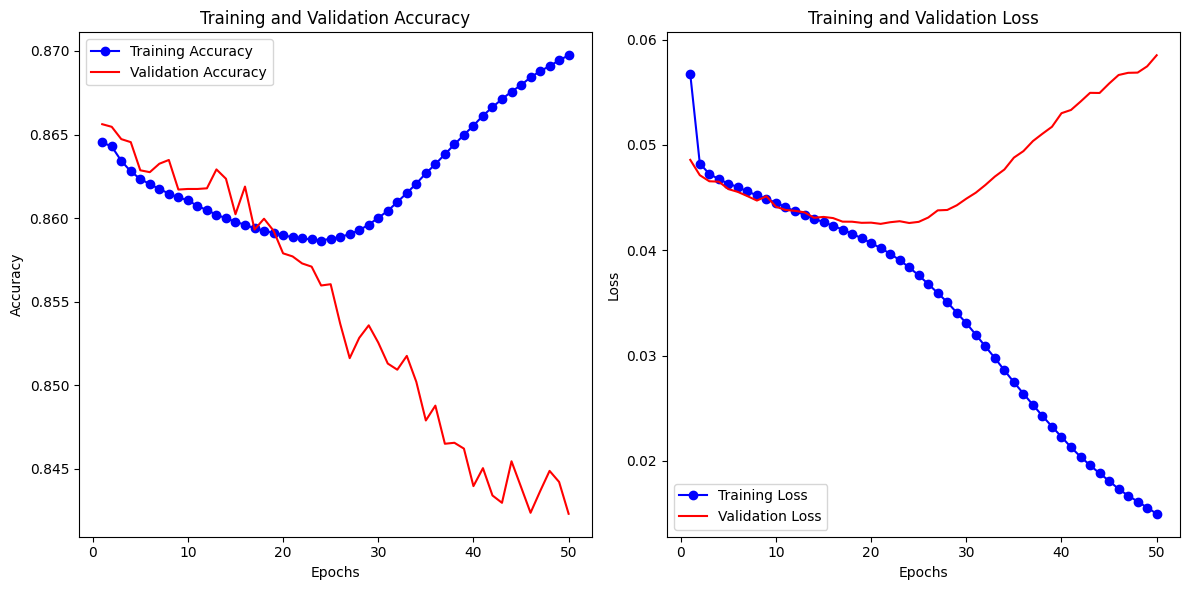

1/1 [==============================] - 1s 609ms/step


In [ ]:
# Your code
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Conv2DTranspose, Reshape
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Conv2DTranspose
import os


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)


X_text_train, X_text_val, y_img_train, y_img_val = train_test_split(X_text, y_img, test_size=0.25, random_state=42)
print(y_img_train.shape)
print(X_text_train[1])
## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

#for _ in range(10):
   # display_sample(np.random.randint(0, 10000, 1)[0])
def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_train_onehot = encode_labels(X_text_train)
X_text_val_onehot = encode_labels(X_text_val)

def reshape_target_data(y_data):
    y_data = y_data.transpose(0, 2, 1, 3)
    return y_data.reshape(-1, 28, 84)

y_img_train_reshaped = reshape_target_data(y_img_train)

y_img_val_reshaped = reshape_target_data(y_img_val)

import matplotlib.pyplot as plt

def show_images(images):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_images_1(images):
    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

#show_images(y_img_val[1])



def build_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape, return_sequences=False))
    reshaped_dim = (output_shape[0] // 4, output_shape[1] // 4, 256)
    dense_output_size = np.prod(reshaped_dim)

    model.add(Dense(dense_output_size, activation='relu'))
    model.add(Reshape(reshaped_dim))

    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid'))
    return model




input_shape = (5, 13)
output_shape = (28, 84, 1)


model = build_model(input_shape, output_shape)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(X_text_train_onehot, y_img_train_reshaped, batch_size=32, epochs=50, validation_data=(X_text_val_onehot, y_img_val_reshaped))

loss, accuracy = model.evaluate(X_text_val_onehot, y_img_val_reshaped)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')
model.save('my_model.h5')

with open('training_history.txt', 'w') as file:
    file.write("Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy\n")
    for epoch in range(len(history.history['loss'])):
        train_loss = history.history['loss'][epoch]
        train_accuracy = history.history['accuracy'][epoch]
        val_loss = history.history['val_loss'][epoch]
        val_accuracy = history.history['val_accuracy'][epoch]
        file.write(f"{epoch+1},{train_loss},{train_accuracy},{val_loss},{val_accuracy}\n")

print("Training history saved to 'training_history.txt'")


train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

plt.savefig('model_performance.png')
plt.show()




sample_to_predict = X_text_val_onehot[1]
sample_to_predict = np.expand_dims(sample_to_predict, axis=0)
predicted_imgs = model.predict(sample_to_predict)

def display_images(predicted_imgs, num_images=1):
    plt.figure(figsize=(10, 2 * num_images))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(predicted_imgs[i].reshape(28, 84), cmap='gray')
        plt.title("Predicted")
        plt.axis("off")
    plt.show()


shown output images of first epoch and 30 times epoch

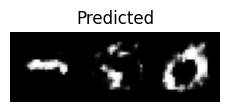

157/157 [==============================] - 1s 5ms/step


In [ ]:
display_images(predicted_imgs, num_images=1)

def save_incorrect_predictions(predictions, actual, num_images=10):
    incorrect_indices = [i for i, (p, a) in enumerate(zip(predictions, actual)) if np.argmax(p) != np.argmax(a)]

    for idx in incorrect_indices[:num_images]:
        predicted_img = predictions[idx].reshape(28, 84)
        actual_img = actual[idx].reshape(28, 84)
        os.makedirs(str(idx), exist_ok=True)
        plt.imsave(f'{idx}/actual_{idx}.png', actual_img, cmap='gray')
        plt.imsave(f'{idx}/predicted_{idx}.png', predicted_img, cmap='gray')

predictions = model.predict(X_text_val_onehot)
save_incorrect_predictions(predictions, y_img_val_reshaped, num_images=10)


predictions = model.predict(X_text_val_onehot)
save_incorrect_predictions(predictions, y_img_val_reshaped, num_images=10)

add more LSTM layers in the model

(15000, 3, 28, 28)
6+33 
Epoch 1/50
500/500 [==============================] - 11s 17ms/step - loss: 0.0568 - accuracy: 0.8647 - val_loss: 0.0487 - val_accuracy: 0.8663
Epoch 2/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0482 - accuracy: 0.8650 - val_loss: 0.0479 - val_accuracy: 0.8654
Epoch 3/50
500/500 [==============================] - 8s 15ms/step - loss: 0.0473 - accuracy: 0.8641 - val_loss: 0.0468 - val_accuracy: 0.8641
Epoch 4/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0467 - accuracy: 0.8633 - val_loss: 0.0466 - val_accuracy: 0.8635
Epoch 5/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0463 - accuracy: 0.8627 - val_loss: 0.0460 - val_accuracy: 0.8635
Epoch 6/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0459 - accuracy: 0.8623 - val_loss: 0.0458 - val_accuracy: 0.8627
Epoch 7/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0456 - accuracy: 0.8620 - val_loss: 0.0

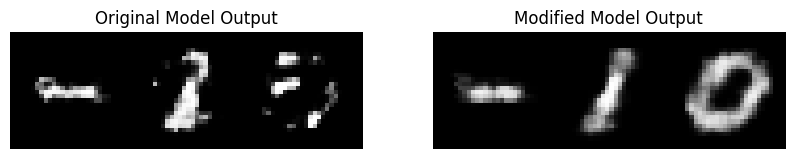

In [ ]:

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)

X_text_train, X_text_val, y_img_train, y_img_val = train_test_split(X_text, y_img, test_size=0.25, random_state=42)
print(y_img_train.shape)
print(X_text_train[1])
## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

#for _ in range(10):
   # display_sample(np.random.randint(0, 10000, 1)[0])
def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_train_onehot = encode_labels(X_text_train)
X_text_val_onehot = encode_labels(X_text_val)

def reshape_target_data(y_data):
    y_data = y_data.transpose(0, 2, 1, 3)
    return y_data.reshape(-1, 28, 84)

y_img_train_reshaped = reshape_target_data(y_img_train)

y_img_val_reshaped = reshape_target_data(y_img_val)

import matplotlib.pyplot as plt

def show_images(images):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_images_1(images):
    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

#show_images(y_img_val[1])



def build_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape, return_sequences=False))
    reshaped_dim = (output_shape[0] // 4, output_shape[1] // 4, 256)
    dense_output_size = np.prod(reshaped_dim)
    model.add(Dense(dense_output_size, activation='relu'))
    model.add(Reshape(reshaped_dim))
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid'))
    return model

def build_model_revised(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(256, input_shape=input_shape, return_sequences=False))
    reshaped_dim = (output_shape[0] // 4, output_shape[1] // 4, 256)
    dense_output_size = np.prod(reshaped_dim)
    model.add(Dense(dense_output_size, activation='relu'))
    model.add(Reshape(reshaped_dim))
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid'))
    return model


input_shape = (5, 13)
output_shape = (28, 84, 1)
model_original = build_model(input_shape, output_shape)
model_original.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_original = model_original.fit(X_text_train_onehot, y_img_train_reshaped, batch_size=30, epochs=50, validation_data=(X_text_val_onehot, y_img_val_reshaped))

model_modified = build_model_revised(input_shape, output_shape)
model_modified.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_modified = model_modified.fit(X_text_train_onehot, y_img_train_reshaped, batch_size=30, epochs=50, validation_data=(X_text_val_onehot, y_img_val_reshaped))

sample_to_predict = X_text_val_onehot[1]
sample_to_predict = np.expand_dims(sample_to_predict, axis=0)

predicted_imgs_original = model_original.predict(sample_to_predict)
predicted_imgs_modified = model_modified.predict(sample_to_predict)


def display_comparison(original, modified):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original.reshape(28, 84), cmap='gray')
    plt.title("Original Model Output")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(modified.reshape(28, 84), cmap='gray')
    plt.title("Modified Model Output")
    plt.axis("off")

    plt.show()

display_comparison(predicted_imgs_original[0], predicted_imgs_modified[0])


---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

(9801,) (9801, 5, 28, 28) (9801,) (9801, 5, 28, 28)
Query #9110

X_text: "93*3 " = y_text: "  279"


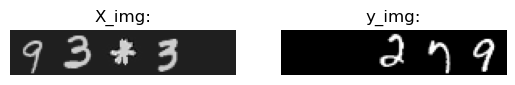

Query #7293

X_text: "74*67" = y_text: " 4958"


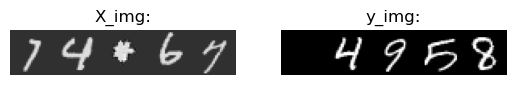

Query #5087

X_text: "52*39" = y_text: " 2028"


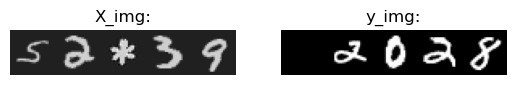

Query #1279

X_text: "13*92" = y_text: " 1196"


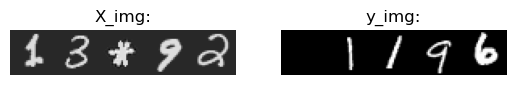

Query #8946

X_text: "91*37" = y_text: " 3367"


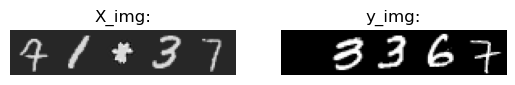

Query #2969

X_text: "30*99" = y_text: " 2970"


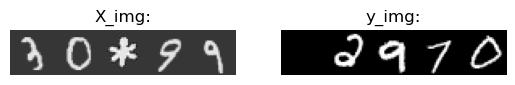

Query #7124

X_text: "72*96" = y_text: " 6912"


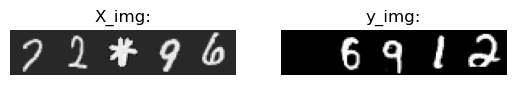

Query #4596

X_text: "47*43" = y_text: " 2021"


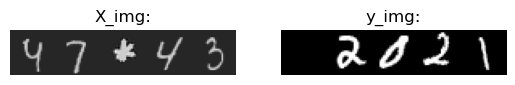

Query #7710

X_text: "78*88" = y_text: " 6864"


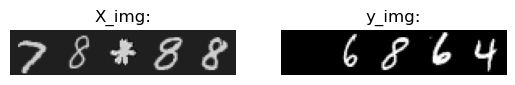

Query #289

X_text: "3*92 " = y_text: "  276"


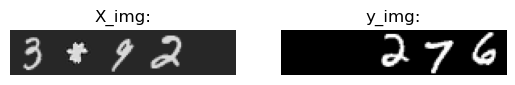

In [12]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

Text to Text

Epoch 1/60
69/69 [==============================] - 24s 146ms/step - loss: 1.6643 - accuracy: 0.4632 - val_loss: 1.3731 - val_accuracy: 0.4887
Epoch 2/60
69/69 [==============================] - 6s 94ms/step - loss: 1.3017 - accuracy: 0.5039 - val_loss: 1.1856 - val_accuracy: 0.5531
Epoch 3/60
69/69 [==============================] - 7s 98ms/step - loss: 1.1423 - accuracy: 0.5571 - val_loss: 1.0381 - val_accuracy: 0.6020
Epoch 4/60
69/69 [==============================] - 7s 98ms/step - loss: 0.9693 - accuracy: 0.6231 - val_loss: 0.8917 - val_accuracy: 0.6494
Epoch 5/60
69/69 [==============================] - 7s 97ms/step - loss: 0.8717 - accuracy: 0.6593 - val_loss: 0.8203 - val_accuracy: 0.6744
Epoch 6/60
69/69 [==============================] - 7s 100ms/step - loss: 0.8395 - accuracy: 0.6664 - val_loss: 0.7596 - val_accuracy: 0.7113
Epoch 7/60
69/69 [==============================] - 7s 102ms/step - loss: 0.7713 - accuracy: 0.6969 - val_loss: 0.7414 - val_accuracy: 0.7102
Epoch 8/6

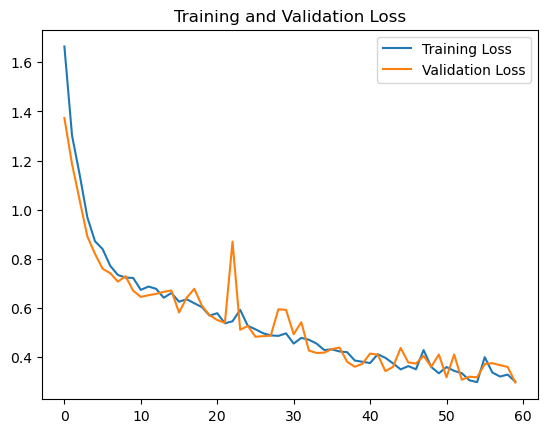

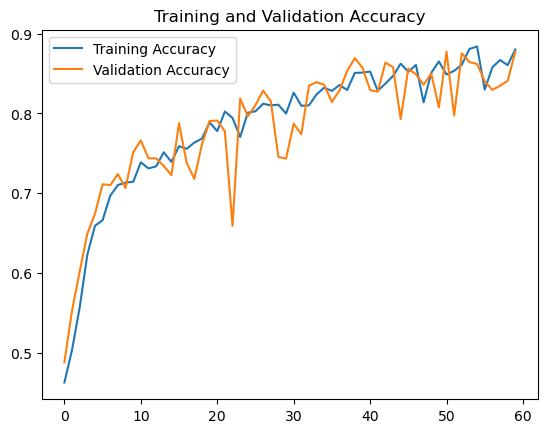

In [18]:
## Your code
from tensorflow.keras.layers import Dropout

def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])
    x = np.random.randint(12, 16, (number_of_images, 2))
    y1 = np.random.randint(6, 10, number_of_images)
    y2 = np.random.randint(18, 22, number_of_images)

    for i in range(number_of_images):
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
        elif sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -45, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def create_data(highest_integer, operands=['+', '-', '*']):
    # 加载 MNIST 数据集
    (MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
    
    # 创建数字图像映射
    num_indices = [np.where(MNIST_labels == i)[0] for i in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = {str(i): num_data[i] for i in range(10)}

    # 为运算符生成图像并添加到映射中
    for op in operands:
        image_mapping[op] = generate_images(sign=op)
    
    # 添加空格符的图像
    image_mapping[' '] = np.zeros((1, 28, 28))

    # 创建文本和图像数据
    X_text, X_img, y_text, y_img = [], [], [], []
    
    for i in range(1, highest_integer + 1):
        for j in range(1, highest_integer + 1):
            for op in operands:
                # 生成算术表达式
                query_string = f"{i}{op}{j}"
                result = str(eval(query_string)).rjust(max_answer_length)

                # 生成对应的图像序列
                query_img_seq = [image_mapping[char][np.random.choice(len(image_mapping[char]))] for char in query_string.ljust(max_query_length)]
                result_img_seq = [image_mapping[char][np.random.choice(len(image_mapping[char]))] for char in result]

                # 添加到数据集中
                X_text.append(query_string.ljust(max_query_length))
                X_img.append(np.stack(query_img_seq))
                y_text.append(result)
                y_img.append(np.stack(result_img_seq))

    return np.array(X_text), np.stack(X_img) / 255., np.array(y_text), np.stack(y_img) / 255.




def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

def encode_labels(labels, max_len):
    char_map = {char: idx for idx, char in enumerate('0123456789* ')}
    one_hot_labels = np.zeros((len(labels), max_len, len(char_map)))

    for i, label in enumerate(labels):
        for j, char in enumerate(label):
            if j < max_len:
                one_hot_labels[i, j, char_map[char]] = 1

    return one_hot_labels


def decode_labels(one_hot_labels):
    char_map = '0123456789* '
    labels = []
    for label in one_hot_labels:
        idxs = label.argmax(axis=-1)
        labels.append(''.join(char_map[idx] for idx in idxs).strip())

    return labels


## Your code

X_text, X_img, y_text, y_img = create_data(99, operands=['*'])

# 初始分割：将数据分为测试集和其余部分（训练集 + 验证集）
X_text_train_val, X_text_test, y_text_train_val, y_text_test = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42)  # 例如，20% 的数据用作测试集

# 第二次分割：将剩余数据分为训练集和验证集
X_text_train, X_text_val, y_text_train, y_text_val = train_test_split(
    X_text_train_val, y_text_train_val, test_size=0.25, random_state=42)  # 从剩余的 80% 中分出 25% 作为验证集

# 独热编码
X_text_train_onehot = encode_labels(X_text_train, max_len=5)
y_text_train_onehot = encode_labels(y_text_train, max_len=3)
X_text_val_onehot = encode_labels(X_text_val, max_len=5)
y_text_val_onehot = encode_labels(y_text_val, max_len=3)

# 对测试集进行独热编码
X_text_test_onehot = encode_labels(X_text_test, max_len=5)
y_text_test_onehot = encode_labels(y_text_test, max_len=3)



def build_text2text_model_revised():
    text2text = tf.keras.Sequential()
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    # text2text.add(Dropout(0.2))  # 添加 Dropout 层
    text2text.add(LSTM(256, return_sequences=True))
    # text2text.add(Dropout(0.2))  # 添加 Dropout 层
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=False))
    text2text.add(RepeatVector(3))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return text2text

model = build_text2text_model_revised()


# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(
    X_text_train_onehot, y_text_train_onehot,
    validation_split=0.25,  # 使用25%的数据作为验证集
    epochs=60,  # 迭代次数可以根据需要进行调整
    batch_size=64  # 批次大小可以根据您的硬件调整
)

# 在验证集上评估模型
test_loss, test_accuracy = model.evaluate(X_text_test_onehot, y_text_test_onehot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# 测试模型
predictions_onehot = model.predict(X_text_test_onehot)
predictions = decode_labels(predictions_onehot)

# 打印部分测试结果
for i in range(10):
    index = np.random.randint(0, len(X_text_test))
    print(f'Query: {X_text_test[index]}, Predicted answer: {predictions[index]}, True answer: {y_text_test[index]}')


# 展示一些预测结果
for i in range(10):
    print(f'Query: {X_text[i]}, Predicted answer: {predictions[i]}, True answer: {y_text[i]}')

# 绘制训练和验证的损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 绘制训练和验证的准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()






Image to Text

X_img_train shape: (6000, 5, 28, 28)
y_train_onehot shape: (6000, 5, 12)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 28, 28,   0           []                               
                                1)]                                                               
                                                                                                  
 time_distributed_110 (TimeDist  (None, 5, 28, 28, 3  320        ['input_9[0][0]']                
 ributed)                       2)                                                                
                                                                                                  
 time_distributed_111 (TimeDist  (None, 5, 28, 28, 3  0          ['time_distributed_110[0][0]']   
 ributed)          

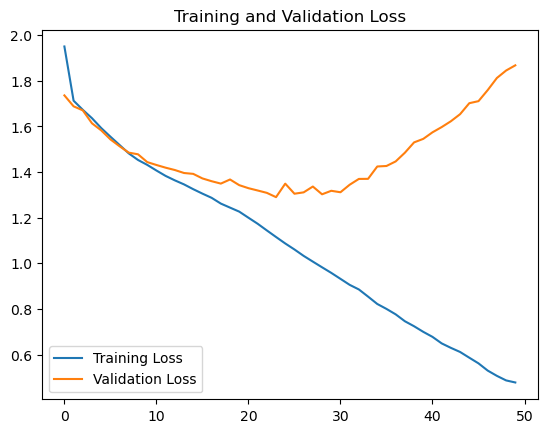

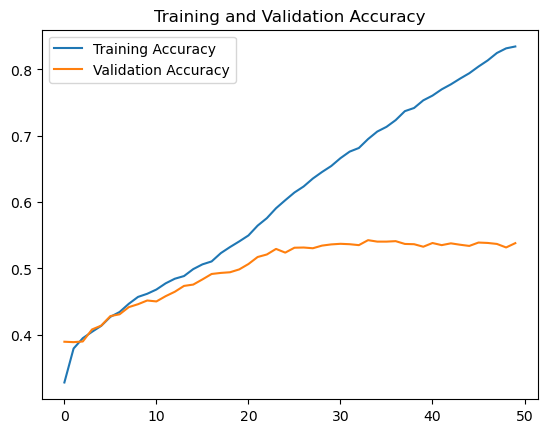

In [9]:
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Activation, Dropout, RepeatVector, Multiply, Permute, Reshape


# 生成运算符图像
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

# 创建数据集
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

# 编码标签
def encode_labels(labels, max_len=5):
    char_map = {char: idx for idx, char in enumerate('0123456789* ')}
    one_hot_labels = np.zeros((len(labels), max_len, len(char_map)))

    for i, label in enumerate(labels):
        # 保证每个标签长度至少为5
        padded_label = label.ljust(max_len)[:max_len]
        for j, char in enumerate(padded_label):
            one_hot_labels[i, j, char_map[char]] = 1

    return one_hot_labels


# 解码标签
def decode_labels(one_hot_labels):
    char_map = '0123456789* '
    labels = []
    for label in one_hot_labels:
        idxs = label.argmax(axis=-1)
        labels.append(''.join(char_map[idx] for idx in idxs).strip())

    return labels


unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])



# 划分数据集
X_img_train_val, X_img_test, y_text_train_val, y_text_test = train_test_split(X_img, y_text, test_size=0.2, random_state=42)
X_img_train, X_img_val, y_text_train, y_text_val = train_test_split(X_img_train_val, y_text_train_val, test_size=0.25, random_state=42)


# 编码标签
y_train_onehot = encode_labels(y_text_train)
y_val_onehot = encode_labels(y_text_val)
y_test_onehot = encode_labels(y_text_test)


print("X_img_train shape:", X_img_train.shape)
print("y_train_onehot shape:", y_train_onehot.shape)

def attention_layer(inputs, time_steps):
    # Attention mechanism layer
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, time_steps))(a)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def build_image_to_text_model(input_shape, output_length, num_chars):
    # Image encoder - using TimeDistributed with Convolutional layers
    input_images = Input(shape=input_shape)

    # TimeDistributed Convolutional layers with Batch Normalization
    td_conv1 = TimeDistributed(Conv2D(32, (3, 3), padding='same'))(input_images)
    # td_bn1 = TimeDistributed(BatchNormalization())(td_conv1)
    td_act1 = TimeDistributed(Activation('relu'))(td_conv1)
    td_pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(td_act1)

    td_conv2 = TimeDistributed(Conv2D(64, (3, 3), padding='same'))(td_pool1)
    # td_bn2 = TimeDistributed(BatchNormalization())(td_conv2)
    td_act2 = TimeDistributed(Activation('relu'))(td_conv2)
    td_pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(td_act2)

    td_conv3 = TimeDistributed(Conv2D(128, (3, 3), padding='same'))(td_pool2)
    # td_bn3 = TimeDistributed(BatchNormalization())(td_conv3)
    td_act3 = TimeDistributed(Activation('relu'))(td_conv3)
    td_pool3 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(td_act3)


    # Flatten the output for input to LSTM
    flattened = TimeDistributed(Flatten())(td_pool3)

    # LSTM layer with attention
    lstm_layer = LSTM(128, return_sequences=True)(flattened)
    attention_mul = attention_layer(lstm_layer, input_shape[0])
    attention_flatten = Flatten()(attention_mul)
    repeat_encoding = RepeatVector(output_length)(attention_flatten)

    # Decoder - LSTM followed by Dense layer for character classification
    lstm_layer2 = LSTM(128, return_sequences=True)(repeat_encoding)
    dropout_layer = Dropout(0.1)(lstm_layer2)

    outputs = TimeDistributed(Dense(num_chars, activation='softmax'))(dropout_layer)

    model = Model(inputs=input_images, outputs=outputs)
    return model

input_shape = (5, 28, 28, 1)
output_length = 5
num_chars = 12
model = build_image_to_text_model(input_shape, output_length, num_chars)
model.compile(optimizer="Nadam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 训练模型
history = model.fit(X_img_train, y_train_onehot, validation_data=(X_img_val, y_val_onehot), epochs=50, batch_size=128)

# 评估模型
val_loss, val_accuracy = model.evaluate(X_img_val, y_val_onehot)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

test_loss, test_accuracy = model.evaluate(X_img_test, y_test_onehot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# 预测
predictions_onehot = model.predict(X_img_test)
predictions = decode_labels(predictions_onehot)

for i in range(10):
    index = np.random.randint(0, len(X_img_test))
    print(f'Image index: {index}, Predicted answer: {predictions[index]}, True answer: {y_text_test[index]}')

# 绘制训练和验证的损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 绘制训练和验证的准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Add Conv2D

X_img_train shape: (6000, 5, 28, 28)
y_train_onehot shape: (6000, 5, 12)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 5, 28, 28,   0           []                               
                                1)]                                                               
                                                                                                  
 conv_lstm2d_2 (ConvLSTM2D)     (None, 5, 28, 28, 6  150016      ['input_12[0][0]']               
                                4)                                                                
                                                                                                  
 batch_normalization_21 (BatchN  (None, 5, 28, 28, 6  256        ['conv_lstm2d_2[0][0]']          
 ormalization)    

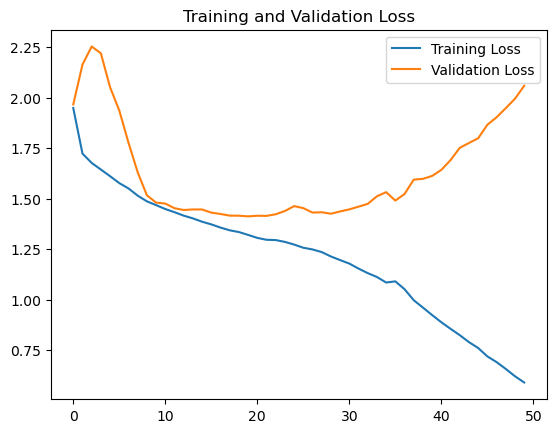

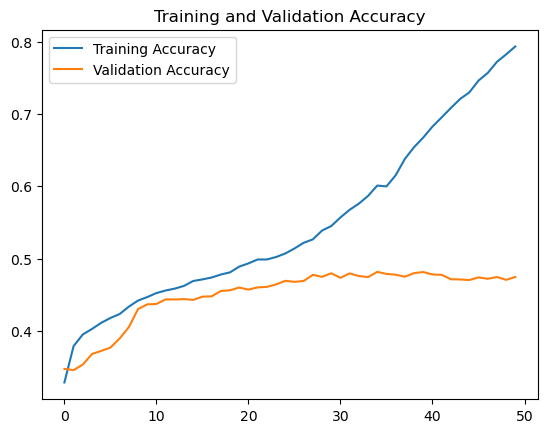

In [12]:
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Activation, Dropout, RepeatVector, Multiply, Permute, Reshape


# 生成运算符图像
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

# 创建数据集
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

# 编码标签
def encode_labels(labels, max_len=5):
    char_map = {char: idx for idx, char in enumerate('0123456789* ')}
    one_hot_labels = np.zeros((len(labels), max_len, len(char_map)))

    for i, label in enumerate(labels):
        # 保证每个标签长度至少为5
        padded_label = label.ljust(max_len)[:max_len]
        for j, char in enumerate(padded_label):
            one_hot_labels[i, j, char_map[char]] = 1

    return one_hot_labels


# 解码标签
def decode_labels(one_hot_labels):
    char_map = '0123456789* '
    labels = []
    for label in one_hot_labels:
        idxs = label.argmax(axis=-1)
        labels.append(''.join(char_map[idx] for idx in idxs).strip())

    return labels


unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])



# 划分数据集
X_img_train_val, X_img_test, y_text_train_val, y_text_test = train_test_split(X_img, y_text, test_size=0.2, random_state=42)
X_img_train, X_img_val, y_text_train, y_text_val = train_test_split(X_img_train_val, y_text_train_val, test_size=0.25, random_state=42)


# 编码标签
y_train_onehot = encode_labels(y_text_train)
y_val_onehot = encode_labels(y_text_val)
y_test_onehot = encode_labels(y_text_test)


print("X_img_train shape:", X_img_train.shape)
print("y_train_onehot shape:", y_train_onehot.shape)

def attention_layer(inputs, time_steps):
    # Attention mechanism layer
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, time_steps))(a)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def build_image_to_text_model(input_shape, output_length, num_chars):
    # Image encoder - using TimeDistributed with Convolutional layers
    input_images = Input(shape=input_shape)

    # ConvLSTM2D Layer
    conv_lstm = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu')(input_images)
    conv_lstm_bn = BatchNormalization()(conv_lstm)

    # TimeDistributed Convolutional layers with Batch Normalization
    td_conv1 = TimeDistributed(Conv2D(32, (3, 3), padding='same'))(conv_lstm_bn)
    td_act1 = TimeDistributed(Activation('relu'))(td_conv1)
    td_pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(td_act1)

    td_conv2 = TimeDistributed(Conv2D(64, (3, 3), padding='same'))(td_pool1)
    td_act2 = TimeDistributed(Activation('relu'))(td_conv2)
    td_pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(td_act2)

    td_conv3 = TimeDistributed(Conv2D(128, (3, 3), padding='same'))(td_pool2)
    td_act3 = TimeDistributed(Activation('relu'))(td_conv3)
    td_pool3 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(td_act3)

    # Flatten the output for input to LSTM
    flattened = TimeDistributed(Flatten())(td_pool3)

    # LSTM layer with attention
    lstm_layer = LSTM(128, return_sequences=True)(flattened)
    attention_mul = attention_layer(lstm_layer, input_shape[0])
    attention_flatten = Flatten()(attention_mul)
    repeat_encoding = RepeatVector(output_length)(attention_flatten)

    # Decoder - LSTM followed by Dense layer for character classification
    lstm_layer2 = LSTM(128, return_sequences=True)(repeat_encoding)
    dropout_layer = Dropout(0.1)(lstm_layer2)

    outputs = TimeDistributed(Dense(num_chars, activation='softmax'))(dropout_layer)

    model = Model(inputs=input_images, outputs=outputs)
    return model

input_shape = (5, 28, 28, 1)
output_length = 5
num_chars = 12
model = build_image_to_text_model(input_shape, output_length, num_chars)
model.compile(optimizer="Nadam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 训练模型
history = model.fit(X_img_train, y_train_onehot, validation_data=(X_img_val, y_val_onehot), epochs=50, batch_size=128)

# 评估模型
val_loss, val_accuracy = model.evaluate(X_img_val, y_val_onehot)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

test_loss, test_accuracy = model.evaluate(X_img_test, y_test_onehot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# 预测
predictions_onehot = model.predict(X_img_test)
predictions = decode_labels(predictions_onehot)

for i in range(10):
    index = np.random.randint(0, len(X_img_test))
    print(f'Image index: {index}, Predicted answer: {predictions[index]}, True answer: {y_text_test[index]}')

# 绘制训练和验证的损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 绘制训练和验证的准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 5, 28, 28,   0           []                               
                                1)]                                                               
                                                                                                  
 time_distributed_168 (TimeDist  (None, 5, 28, 28, 3  320        ['input_14[0][0]']               
 ributed)                       2)                                                                
                                                                                                  
 time_distributed_169 (TimeDist  (None, 5, 28, 28, 3  128        ['time_distributed_168[0][0]']   
 ributed)                       2)                                                         

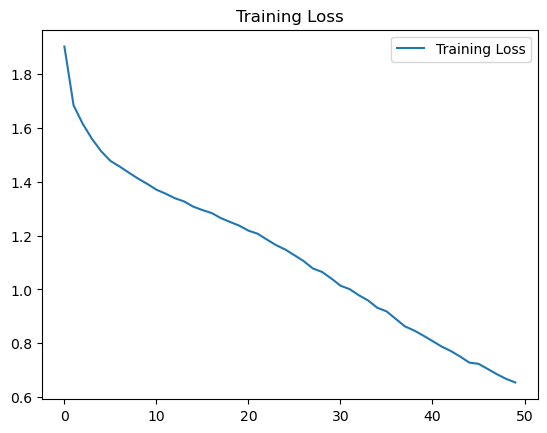

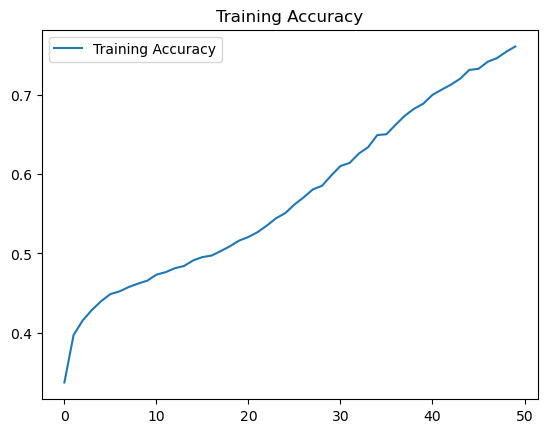

In [14]:
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Activation, Dropout, RepeatVector, Multiply, Permute, Reshape


# 生成运算符图像
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

# 创建数据集
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

# 编码标签
def encode_labels(labels, max_len=5):
    char_map = {char: idx for idx, char in enumerate('0123456789* ')}
    one_hot_labels = np.zeros((len(labels), max_len, len(char_map)))

    for i, label in enumerate(labels):
        # 保证每个标签长度至少为5
        padded_label = label.ljust(max_len)[:max_len]
        for j, char in enumerate(padded_label):
            one_hot_labels[i, j, char_map[char]] = 1

    return one_hot_labels


# 解码标签
def decode_labels(one_hot_labels):
    char_map = '0123456789* '
    labels = []
    for label in one_hot_labels:
        idxs = label.argmax(axis=-1)
        labels.append(''.join(char_map[idx] for idx in idxs).strip())

    return labels


unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])


# 划分数据集为训练集和测试集，这里以80%数据为训练集，20%为测试集
X_img_train, X_img_test, y_text_train, y_text_test = train_test_split(X_img, y_text, test_size=0.2, random_state=42)

# 如果您需要对标签进行独热编码
y_train_onehot = encode_labels(y_text_train)
y_test_onehot = encode_labels(y_text_test)


def attention_layer(inputs, time_steps):
    # Attention mechanism layer
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, time_steps))(a)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def build_image_to_text_model(input_shape, output_length, num_chars):
    # Image encoder - using TimeDistributed with Convolutional layers
    input_images = Input(shape=input_shape)

    # TimeDistributed Convolutional layers with Batch Normalization
    td_conv1 = TimeDistributed(Conv2D(32, (3, 3), padding='same'))(input_images)
    td_bn1 = TimeDistributed(BatchNormalization())(td_conv1)
    td_act1 = TimeDistributed(Activation('relu'))(td_bn1)
    td_pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(td_act1)

    td_conv2 = TimeDistributed(Conv2D(64, (3, 3), padding='same'))(td_pool1)
    td_bn2 = TimeDistributed(BatchNormalization())(td_conv2)
    td_act2 = TimeDistributed(Activation('relu'))(td_bn2)
    td_pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(td_act2)

    td_conv3 = TimeDistributed(Conv2D(128, (3, 3), padding='same'))(td_pool2)
    td_bn3 = TimeDistributed(BatchNormalization())(td_conv3)
    td_act3 = TimeDistributed(Activation('relu'))(td_bn3)
    td_pool3 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(td_act3)

    # Flatten the output for input to LSTM
    flattened = TimeDistributed(Flatten())(td_pool3)

    # LSTM layer with attention
    lstm_layer = LSTM(128, return_sequences=True)(flattened)
    attention_mul = attention_layer(lstm_layer, input_shape[0])
    attention_flatten = Flatten()(attention_mul)
    repeat_encoding = RepeatVector(output_length)(attention_flatten)

    # Decoder - LSTM followed by Dense layer for character classification
    lstm_layer2 = LSTM(128, return_sequences=True)(repeat_encoding)
    dropout_layer = Dropout(0.5)(lstm_layer2)

    outputs = TimeDistributed(Dense(num_chars, activation='softmax'))(dropout_layer)

    model = Model(inputs=input_images, outputs=outputs)
    return model

input_shape = (5, 28, 28, 1)
output_length = 5
num_chars = 12
model = build_image_to_text_model(input_shape, output_length, num_chars)
model.compile(optimizer="Nadam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 训练模型
history = model.fit(X_img_train, y_train_onehot,  epochs=50, batch_size=128, shuffle=True)

# 评估模型
test_loss, test_accuracy = model.evaluate(X_img_test, y_test_onehot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


# 预测
predictions_onehot = model.predict(X_img_test)
predictions = decode_labels(predictions_onehot)

for i in range(10):
    index = np.random.randint(0, len(X_img_test))
    print(f'Image index: {index}, Predicted answer: {predictions[index]}, True answer: {y_text_test[index]}')

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# 绘制训练准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()
